## **Fake news classifier using LSTM**

**Dataset Link: https://www.kaggle.com/c/fake-news/data?select=train.csv**

In [1]:
# !pip install --upgrade scikit-learn pandas numpy

In [2]:
# Import necessary library

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential

In [3]:
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("NLTK version: ", nltk.__version__)
print("Scikit-learn version: ", sklearn.__version__)
print("Tensorflow version: ", tf.__version__)


# Pandas version:  1.3.5
# Numpy version:  1.21.6
# NLTK version:  3.7
# Scikit-learn version:  1.0.2
# Tensorflow version:  2.8.2

Pandas version:  1.3.5
Numpy version:  1.21.6
NLTK version:  3.7
Scikit-learn version:  1.0.2
Tensorflow version:  2.8.2


In [4]:
# Load the datasets

df = pd.read_csv("/content/drive/MyDrive/Machine Learning/NLP/Word Embedding/datasets/train.csv")

df.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [5]:
# Check the shape

df.shape

(20800, 5)

In [6]:
# Check the dimension

df.ndim

2

In [7]:
# Check the null values

df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
# Find the total null in the entire dataset

df.isna().sum().sum()

2554

In [9]:
# Check the info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [10]:
# Check the duplicate rows or values has or not

df.duplicated().any()

False

In [11]:
# Check the number of unique author in the author column

df['author'].unique()

array(['Darrell Lucus', 'Daniel J. Flynn', 'Consortiumnews.com', ...,
       'D. Samuelson', 'Judge Andrew Napolitano',
       'Michael J. de la Merced and Rachel Abrams'], dtype=object)

In [12]:
# Find the total unique author in the author column

len(df['author'].unique())

4202

In [13]:
# Drop NaN vlaues from the dataset

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
# Now check again is there any null value has or not

df.isnull().sum().sum()

0

### **Spliting the independent and dependent features**

In [15]:
# Get the independent features

X = df.drop(labels='label', axis=1) # axis = 1 means column wise or axis='columns'

In [16]:
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [17]:
# Get the dependent features

y = df['label']

In [68]:
# Check the count of each class
y.value_counts()

0    10361
1     7924
Name: label, dtype: int64

In [18]:
# Check the shape of X

X.shape

(18285, 4)

In [19]:
# Check the shape of y

y.shape

(18285,)

# **Text preprocessing**

In [20]:
all_messages = X.copy()

In [21]:
all_messages.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [22]:
all_messages.loc[0, 'title']

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [23]:
all_messages.loc[100, 'title']

'Snap Shares Leap 44% in Debut as Investors Doubt Value Will Vanish - The New York Times'

In [24]:
all_messages.loc[18000, 'title']

'Samantha Bee Mocks Trump, Roasts Media at ’Not the White House Correspondents’ Dinner’ - Breitbart'

In [25]:
all_messages.loc[0, 'text']

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [26]:
all_messages.loc[3, 'text']

'Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations.   Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the biggest loss of civilian life in one strike since the attack on the Medecins Sans Frontieres hospital (MSF) last October. \nThe US claimed it had conducted a “counter-terrorism” strike against Islamic State (IS) fighters when it hit Nangarhar province with missiles on September 28. But the next day the United Nations issued an unusually rapid and strong statement saying the strike had killed 15 civilians and injured 13 others who had gathered at a house to celebrate a tribal elder’s return from a pil

**As we can see, the 'text' column contain lots of sentences. So, if we work with 'title, 'author' and 'text' column then it will be take much more time to train our model. For this reason, I skip the text and also author column. I skiping author column because of this column is not much more important with respect to 'text' and 'title' column. Thus, I gonna work with 'title' column only. If you have enought GPU, CPU and RAM and also enought time then you can add 'text' column to train the deep learning model in the same way.**

In [27]:
nltk.download(info_or_id='stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
# Let's check the length of all_messages

len(all_messages)

18285

In [29]:
# Apply PorterStemmer for word stemming

ps = PorterStemmer()

In [30]:
corpus = []

for i in range(len(all_messages)):
    text = re.sub(pattern=r"[^a-zA-Z]", repl=" ", string=all_messages.loc[i, "title"])
    text = text.lower()
    text = text.split()

    text = [ps.stem(word=word) for word in text if word not in stopwords.words("english")]
    text = " ".join(text)
    corpus.append(text)

In [31]:
corpus

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag',
 'russian research discov secret nazi militari base treasur hunter arctic photo',
 'us offici see link trump russia',
 'ye paid govern troll social media blog forum websit',
 'major leagu soccer argentin find home success new york time',
 'well fargo chief abruptli step new york time',
 'anonym donor pay million releas everyon arrest dakota access pipelin',
 'fbi close hilla

## **One-hot representation of our unique corpus**

In [32]:
# Let's define our vocabulary size

vocab_size = 7000

one_hot_representation = [one_hot(input_text=word, n=vocab_size) for word in corpus]

In [33]:
# one-hot representation for every sentences in the corpus.
# this all the index number for all the words in a sentence in the corpus

# I just display only for 50 sentences
one_hot_representation[0:50]

[[1375, 1638, 615, 4393, 6083, 2060, 3671, 2346, 617, 2038],
 [2860, 4697, 3313, 6246, 6394, 4897, 2094],
 [3906, 387, 1655, 1344],
 [97, 1086, 2227, 4842, 5026, 6581],
 [3533, 6394, 4410, 5394, 4655, 863, 6394, 3961, 2087, 5475],
 [2882,
  70,
  6604,
  2326,
  5706,
  5886,
  1747,
  3915,
  283,
  4531,
  3257,
  3981,
  857,
  1345,
  2094],
 [4393, 402, 3468, 3242, 2137, 3617, 3144, 4300, 6328, 6296, 2562],
 [5124, 1891, 2168, 4106, 775, 5500, 5886, 2074, 6328, 6296, 2562],
 [4662, 4680, 5390, 3250, 1576, 4853, 2853, 4674, 5886, 4833],
 [129, 1318, 5195, 6062, 2032, 2373, 126, 5443],
 [4771, 6610, 3029, 1040, 2357, 56, 3969, 57, 2183, 6668, 675],
 [4842, 6710, 6083, 4853, 5886, 775],
 [2553, 2163, 6504, 4071, 2433, 4770, 3637, 1175, 1544],
 [2227, 2379, 4976, 6850, 133, 3733, 3106, 6328, 6296, 2562],
 [6666, 298, 1002, 537, 3280, 6328, 6296, 2562],
 [5082, 5418, 1455, 5930, 5335, 6378, 4518, 1706, 5449, 3780],
 [820, 957, 4697],
 [2790, 4097, 441, 4322, 5886, 3021, 5330, 2094],
 [

In [34]:
# Check the data type of the number 

type(one_hot_representation[0][0])

int

In [35]:
# Check the lenght of the one-hot-representation

len(one_hot_representation)

18285

In [36]:
# Now we have to find the max length for the largest sentence to our entire one-hot-representation

def longest_sentence(mylist):
    longest_list = max(len(elem) for elem in mylist)
    return longest_list

In [37]:
sentence_length = longest_sentence(mylist=one_hot_representation)

sentence_length

47

## **Make all the sentence same size**

In [38]:
embedded_docs = pad_sequences(sequences=one_hot_representation, maxlen=sentence_length, padding='pre')

In [39]:
embedded_docs

array([[   0,    0,    0, ..., 2346,  617, 2038],
       [   0,    0,    0, ..., 6394, 4897, 2094],
       [   0,    0,    0, ...,  387, 1655, 1344],
       ...,
       [   0,    0,    0, ..., 6328, 6296, 2562],
       [   0,    0,    0, ..., 3782, 3591, 5974],
       [   0,    0,    0, ...,  454, 2586, 5371]], dtype=int32)

In [40]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 1375, 1638,  615, 4393, 6083, 2060, 3671,
       2346,  617, 2038], dtype=int32)

# **Let's create our model**

In [41]:
# Let's define our dimensions or features that we are want to create

embedding_vector_features = 80

model = Sequential()

model.add(layer=Embedding(input_dim=vocab_size, 
                          output_dim=embedding_vector_features, 
                          input_length=sentence_length))
model.add(layer=Dropout(rate=0.3)) # To reduce the overfitting condition
# Add One LSTM layer with 100 neurons
model.add(layer=LSTM(units=100))
model.add(layer=Dropout(rate=0.3)) # To reduce the overfitting condition
model.add(layer=Dense(units=1, activation="sigmoid")) # sigmoid will give us value between 0 to 1
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 80)            560000    
                                                                 
 dropout (Dropout)           (None, 47, 80)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               72400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 632,501
Trainable params: 632,501
Non-trainable params: 0
_________________________________________________________________


In [43]:
len(embedded_docs), y.shape

(18285, (18285,))

In [44]:
type(embedded_docs)

numpy.ndarray

In [45]:
embedded_docs.shape

(18285, 47)

In [46]:
embedded_docs

array([[   0,    0,    0, ..., 2346,  617, 2038],
       [   0,    0,    0, ..., 6394, 4897, 2094],
       [   0,    0,    0, ...,  387, 1655, 1344],
       ...,
       [   0,    0,    0, ..., 6328, 6296, 2562],
       [   0,    0,    0, ..., 3782, 3591, 5974],
       [   0,    0,    0, ...,  454, 2586, 5371]], dtype=int32)

In [47]:
type(y)

pandas.core.series.Series

In [48]:
y[0 : 20]

0     1
1     0
2     1
3     1
4     1
5     0
6     0
7     0
8     0
9     0
10    1
11    1
12    1
13    0
14    0
15    1
16    1
17    0
18    0
19    0
Name: label, dtype: int64

In [49]:
X_final = np.array(embedded_docs)

y_final = np.array(y)

In [50]:
type(X_final)

numpy.ndarray

In [51]:
X_final.shape

(18285, 47)

In [52]:
X_final

array([[   0,    0,    0, ..., 2346,  617, 2038],
       [   0,    0,    0, ..., 6394, 4897, 2094],
       [   0,    0,    0, ...,  387, 1655, 1344],
       ...,
       [   0,    0,    0, ..., 6328, 6296, 2562],
       [   0,    0,    0, ..., 3782, 3591, 5974],
       [   0,    0,    0, ...,  454, 2586, 5371]], dtype=int32)

In [53]:
type(y_final)

numpy.ndarray

In [54]:
y_final.shape

(18285,)

In [55]:
y_final

array([1, 0, 1, ..., 0, 1, 1])

## **Now split the data into training and test set**

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=True)

In [57]:
X_train

array([[   0,    0,    0, ..., 1767, 4736, 2094],
       [   0,    0,    0, ..., 1238, 4937, 2094],
       [   0,    0,    0, ..., 6328, 6296, 2562],
       ...,
       [   0,    0,    0, ...,  610, 1400, 4615],
       [   0,    0,    0, ..., 6610, 1096, 2094],
       [   0,    0,    0, ..., 6328, 6296, 2562]], dtype=int32)

In [58]:
X_train.shape

(12250, 47)

In [59]:
X_test.shape

(6035, 47)

In [60]:
y_train

array([0, 0, 0, ..., 1, 0, 0])

In [61]:
y_train.shape

(12250,)

# **Model Training**

In [62]:
model.fit(x=X_train, y=y_train, batch_size=80, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
154/154 [==============================] - 17s 95ms/step - loss: 0.3436 - accuracy: 0.8346 - val_loss: 0.1905 - val_accuracy: 0.9178
Epoch 2/30
154/154 [==============================] - 15s 100ms/step - loss: 0.1408 - accuracy: 0.9464 - val_loss: 0.1800 - val_accuracy: 0.9236
Epoch 3/30
154/154 [==============================] - 14s 93ms/step - loss: 0.0979 - accuracy: 0.9652 - val_loss: 0.2017 - val_accuracy: 0.9140
Epoch 4/30
154/154 [==============================] - 15s 98ms/step - loss: 0.0678 - accuracy: 0.9776 - val_loss: 0.2542 - val_accuracy: 0.9258
Epoch 5/30
154/154 [==============================] - 14s 93ms/step - loss: 0.0442 - accuracy: 0.9857 - val_loss: 0.3032 - val_accuracy: 0.9234
Epoch 6/30
154/154 [==============================] - 14s 92ms/step - loss: 0.0345 - accuracy: 0.9898 - val_loss: 0.3128 - val_accuracy: 0.9228
Epoch 7/30
154/154 [==============================] - 14s 94ms/step - loss: 0.0213 - accuracy: 0.9940 - val_loss: 0.3637 - val_accuracy

## **Performance Metrics and Accuracy**

In [63]:
y_pred = model.predict(x=X_test)

In [64]:
y_pred

array([[9.9994624e-01],
       [9.9999803e-01],
       [1.1017526e-09],
       ...,
       [9.9988794e-01],
       [9.9999905e-01],
       [9.9999219e-01]], dtype=float32)

## **If we don't fix it, then it will be throw like this error**

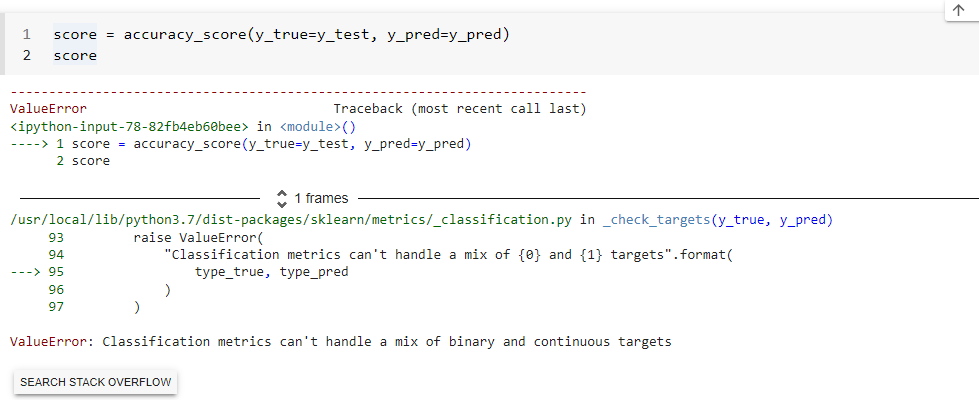

In [65]:
# We can solve this problem in a two ways

# First way

y_predict = y_pred.round()

# Second way

y_predict2 = (y_pred > 0.5) # 0.5 is a threshold value

In [66]:
model.predict_on_batch(x=X_test)

array([[9.9994624e-01],
       [9.9999803e-01],
       [1.1017526e-09],
       ...,
       [9.9988794e-01],
       [9.9999905e-01],
       [9.9999219e-01]], dtype=float32)

## **Accuracy Score**

In [67]:
score = accuracy_score(y_true=y_test, y_pred=y_predict)
score

0.9154929577464789

## **Confusion matrix**

In [69]:
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
cm

array([[3143,  298],
       [ 212, 2382]])

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

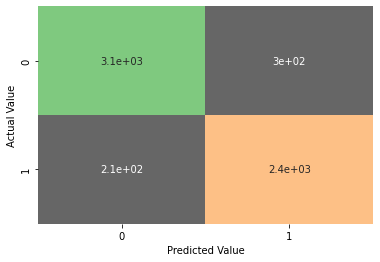

In [71]:
a = pd.DataFrame(data=cm)
sns.heatmap(data=a, cmap=plt.cm.Accent_r, annot=True, cbar=False)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

## **Precision Score**

In [72]:
precision_score(y_true=y_test, y_pred=y_predict)

0.8888059701492538

## **Recall Score**

In [73]:
recall_score(y_true=y_test, y_pred=y_predict)

0.9182729375481882

## **F-1 Score**

In [74]:
f1_score(y_true=y_test, y_pred=y_predict)

0.9032992036405008

In [75]:
# Demo test

10e5

1000000.0

In [76]:
5.2e3

5200.0

In [77]:
45e-3

0.045

In [78]:
3.1e+03

3100.0

In [79]:
3.1e3

3100.0